## Simulating Coronary Artery Obstruction Prediction

This notebook, aims to replicate a clinical research workflow for detecting significant coronary artery obstruction (≥70%) using AI applied. Inspired by a real-world protocol that validates AI predictions against coronary angiography in low-to-intermediate cardiovascular risk patients, this simulation uses the public PTB-XL dataset as a proxy for preliminary model development.

### Global Variables

In [48]:
import ast
import math
import matplotlib.pyplot as plt
import neurokit2 as nk
import numpy as np
import pandas as pd
import re
from scipy.stats import boxcox
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from tabulate import tabulate
import tensorflow as tf
from tensorflow.keras import layers, models
from tqdm import tqdm
import wfdb

### 1. Loading the Dataset

In [2]:
# Paths
ptbxl_path = '/Users/juliapinedo/Desktop/ptb-xl/ptbxl_database.csv'
scp_path = '/Users/juliapinedo/Desktop/ptb-xl/scp_statements.csv'

# Load ECG dataframe
df = pd.read_csv(ptbxl_path, index_col='ecg_id')
# Convert scp_codes into Python dictionary for data filtering
df['scp_codes'] = df['scp_codes'].apply(ast.literal_eval)

# Load SCP dataframe
scp_df = pd.read_csv(scp_path, index_col=0)

In [3]:
# Expand each ECG's scp_codes into a flat list (for merging)
df_expanded = df[['scp_codes']].explode('scp_codes')
df_expanded = df_expanded.reset_index()

# Create a row per SCP code (key) and merge with scp_df info
# Each ECG may have multiple diagnostic codes
df_codes = []
for idx, row in df.iterrows():
    for scp_code in row['scp_codes'].keys():
        if scp_code in scp_df.index:
            combined_row = {
                'ecg_id': idx,
                'scp_code': scp_code,
                'scp_weight': row['scp_codes'][scp_code],
            }
            combined_row.update(scp_df.loc[scp_code].to_dict())
            df_codes.append(combined_row)

# Final merged dataframe
df_ecg_scp = pd.DataFrame(df_codes)

# Merge back other metadata if needed
df_ecg_scp = df_ecg_scp.merge(df.drop(columns=['scp_codes']), left_on='ecg_id', right_index=True, how='left')
df_ecg_scp

,ecg_id,scp_code,scp_weight,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,NORM,100.0,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,1,LVOLT,0.0,low QRS voltages in the frontal and horizontal...,NaN,1.0,NaN,NaN,NaN,Other QRS morphology descriptive statements,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,1,SR,0.0,sinus rhythm,NaN,NaN,1.0,NaN,NaN,Statements related to impulse formation (abnor...,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
3,2,NORM,80.0,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
4,2,SBRAD,0.0,sinus bradycardia,NaN,NaN,1.0,NaN,NaN,Statements related to impulse formation (abnor...,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61114,21835,SR,0.0,sinus rhythm,NaN,NaN,1.0,NaN,NaN,Statements related to impulse formation (abnor...,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr
61115,21836,NORM,100.0,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,...,True,NaN,NaN,NaN,NaN,SVES,NaN,8,records100/21000/21836_lr,records500/21000/21836_hr
61116,21836,SR,0.0,sinus rhythm,NaN,NaN,1.0,NaN,NaN,Statements related to impulse formation (abnor...,...,True,NaN,NaN,NaN,NaN,SVES,NaN,8,records100/21000/21836_lr,records500/21000/21836_hr
61117,21837,NORM,100.0,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,...,True,NaN,", I-AVL,",NaN,NaN,NaN,NaN,9,records100/21000/21837_lr,records500/21000/21837_hr


### 2. Classifying variables

In [4]:
# Let's get a better idea of the dataset structure by printing 
# it's number of (rows, columns)

df_ecg_scp.shape

(61119, 41)

In [5]:
# Let's see the names of the columns in the dataset

df_ecg_scp.columns

Index(['ecg_id', 'scp_code', 'scp_weight', 'description', 'diagnostic', 'form',
       'rhythm', 'diagnostic_class', 'diagnostic_subclass',
       'Statement Category', 'SCP-ECG Statement Description', 'AHA code',
       'aECG REFID', 'CDISC Code', 'DICOM Code', 'patient_id', 'age', 'sex',
       'height', 'weight', 'nurse', 'site', 'device', 'recording_date',
       'report', 'heart_axis', 'infarction_stadium1', 'infarction_stadium2',
       'validated_by', 'second_opinion', 'initial_autogenerated_report',
       'validated_by_human', 'baseline_drift', 'static_noise', 'burst_noise',
       'electrodes_problems', 'extra_beats', 'pacemaker', 'strat_fold',
       'filename_lr', 'filename_hr'],
      dtype='object')

In [6]:
# Let's get a description of the columns that are part of the dataset,
# including the data type and the "non-null" values

df_ecg_scp.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61119 entries, 0 to 61118
Data columns (total 41 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ecg_id                         61119 non-null  int64  
 1   scp_code                       61119 non-null  object 
 2   scp_weight                     61119 non-null  float64
 3   description                    61119 non-null  object 
 4   diagnostic                     30793 non-null  float64
 5   form                           12014 non-null  float64
 6   rhythm                         21210 non-null  float64
 7   diagnostic_class               30793 non-null  object 
 8   diagnostic_subclass            30793 non-null  object 
 9   Statement Category             61119 non-null  object 
 10  SCP-ECG Statement Description  61119 non-null  object 
 11  AHA code                       49508 non-null  float64
 12  aECG REFID                     28769 non-null 

In [7]:
# In total, there are 41 columns. Since the number is greater
# than 10, a function will be created to print two tables: one
# containing each numerical (quantitative) variable, and another
# to classify each qualitative variable.

# Separate columns into numerical (dtype = int, float) and qualitative (dtype = object)
quantitative_columns = df_ecg_scp.select_dtypes(include=['int', 'float']).columns
qualitative_columns = df_ecg_scp.select_dtypes(include=['object']).columns

# Declare an empty list to store the data that will be used
# to generate the new dataframe
data_types = []

# "For" loop to get the data types of each column
for col in df_ecg_scp.columns:
    if col in quantitative_columns:
        data_type = "Numeric"  # Label for numeric type
    elif col in qualitative_columns:
        data_type = "Object"   # Label for qualitative type
    data_types.append((col, data_type))  # Save column labels in the list

# Create a DataFrame for numeric columns
quantitative_df = pd.DataFrame([i for i in data_types if i[1] == "Numeric"],
                               columns=["Variable", "Category"])

# Create a DataFrame for text (qualitative) columns
qualitative_df = pd.DataFrame([i for i in data_types if i[1] == "Object"],
                              columns=["Variable", "Category"])

# Print the tables with the data
print('Quantitative Columns:')
print(tabulate(quantitative_df, headers="keys", tablefmt="psql", showindex=True))
print('\n')
print('Qualitative Columns:')
print(tabulate(qualitative_df, headers="keys", tablefmt="psql", showindex=True))

Quantitative Columns:
+----+------------------------------+------------+
|    | Variable                     | Category   |
|----+------------------------------+------------|
|  0 | ecg_id                       | Numeric    |
|  1 | scp_weight                   | Numeric    |
|  2 | diagnostic                   | Numeric    |
|  3 | form                         | Numeric    |
|  4 | rhythm                       | Numeric    |
|  5 | AHA code                     | Numeric    |
|  6 | patient_id                   | Numeric    |
|  7 | age                          | Numeric    |
|  8 | sex                          | Numeric    |
|  9 | height                       | Numeric    |
| 10 | weight                       | Numeric    |
| 11 | nurse                        | Numeric    |
| 12 | site                         | Numeric    |
| 13 | validated_by                 | Numeric    |
| 14 | second_opinion               | Numeric    |
| 15 | initial_autogenerated_report | Numeric    |
| 16 | va

In [8]:
# According to the dataset information, there are a few columns
# that we could drop, for example:
# nurse, site, device, recording_date, heart_axis, validated_by, 
# second_opinion, initial_autogenerated_report, validated_by_human

# Those variables are not relevant for our prediction
columns_to_remove = ['nurse', 'site', 'device', 'recording_date', 
                     'heart_axis', 'validated_by', 
                     'second_opinion', 'initial_autogenerated_report', 
                     'validated_by_human', 'patient_id']

# Remove the columns
df_ecg_scp.drop(columns=columns_to_remove, axis=1, inplace=True)

# Print the dataframe
df_ecg_scp

,ecg_id,scp_code,scp_weight,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,...,infarction_stadium2,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,NORM,100.0,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,...,NaN,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,1,LVOLT,0.0,low QRS voltages in the frontal and horizontal...,NaN,1.0,NaN,NaN,NaN,Other QRS morphology descriptive statements,...,NaN,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,1,SR,0.0,sinus rhythm,NaN,NaN,1.0,NaN,NaN,Statements related to impulse formation (abnor...,...,NaN,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
3,2,NORM,80.0,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
4,2,SBRAD,0.0,sinus bradycardia,NaN,NaN,1.0,NaN,NaN,Statements related to impulse formation (abnor...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61114,21835,SR,0.0,sinus rhythm,NaN,NaN,1.0,NaN,NaN,Statements related to impulse formation (abnor...,...,NaN,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr
61115,21836,NORM,100.0,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,...,NaN,NaN,NaN,NaN,NaN,SVES,NaN,8,records100/21000/21836_lr,records500/21000/21836_hr
61116,21836,SR,0.0,sinus rhythm,NaN,NaN,1.0,NaN,NaN,Statements related to impulse formation (abnor...,...,NaN,NaN,NaN,NaN,NaN,SVES,NaN,8,records100/21000/21836_lr,records500/21000/21836_hr
61117,21837,NORM,100.0,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,...,NaN,NaN,", I-AVL,",NaN,NaN,NaN,NaN,9,records100/21000/21837_lr,records500/21000/21837_hr


In [9]:
# According to "Hands-On Machine Learning with Scikit-Learn" literature, 
# a standard practice is to: Drop a column if more than 30–50% of its 
# values are missing, so we'll use a function to handle this.

num_elements, _ = df_ecg_scp.shape # Total number of elements

# Percentage of about 51% of non-null values
percentage_51 = math.floor(num_elements * 0.51) # Make sure the value is an int

# Drop the columns that do not contain at least 51% of non-null values
df_ecg_scp = df_ecg_scp.dropna(axis=1, thresh=percentage_51)
df_ecg_scp

,ecg_id,scp_code,scp_weight,description,Statement Category,SCP-ECG Statement Description,AHA code,age,sex,report,strat_fold,filename_lr,filename_hr
0,1,NORM,100.0,normal ECG,Normal/abnormal,normal ECG,1.0,56.0,1,sinusrhythmus periphere niederspannung,3,records100/00000/00001_lr,records500/00000/00001_hr
1,1,LVOLT,0.0,low QRS voltages in the frontal and horizontal...,Other QRS morphology descriptive statements,low QRS voltages in the frontal and horizontal...,NaN,56.0,1,sinusrhythmus periphere niederspannung,3,records100/00000/00001_lr,records500/00000/00001_hr
2,1,SR,0.0,sinus rhythm,Statements related to impulse formation (abnor...,sinus rhythm,20.0,56.0,1,sinusrhythmus periphere niederspannung,3,records100/00000/00001_lr,records500/00000/00001_hr
3,2,NORM,80.0,normal ECG,Normal/abnormal,normal ECG,1.0,19.0,0,sinusbradykardie sonst normales ekg,2,records100/00000/00002_lr,records500/00000/00002_hr
4,2,SBRAD,0.0,sinus bradycardia,Statements related to impulse formation (abnor...,sinus bradycardia,22.0,19.0,0,sinusbradykardie sonst normales ekg,2,records100/00000/00002_lr,records500/00000/00002_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61114,21835,SR,0.0,sinus rhythm,Statements related to impulse formation (abnor...,sinus rhythm,20.0,59.0,1,sinusrhythmus lagetyp normal t abnorm in anter...,2,records100/21000/21835_lr,records500/21000/21835_hr
61115,21836,NORM,100.0,normal ECG,Normal/abnormal,normal ECG,1.0,64.0,1,supraventrikulÄre extrasystole(n) sinusrhythmu...,8,records100/21000/21836_lr,records500/21000/21836_hr
61116,21836,SR,0.0,sinus rhythm,Statements related to impulse formation (abnor...,sinus rhythm,20.0,64.0,1,supraventrikulÄre extrasystole(n) sinusrhythmu...,8,records100/21000/21836_lr,records500/21000/21836_hr
61117,21837,NORM,100.0,normal ECG,Normal/abnormal,normal ECG,1.0,68.0,0,sinusrhythmus p-sinistrocardiale lagetyp norma...,9,records100/21000/21837_lr,records500/21000/21837_hr


In [10]:
# Let's check the new number of (rows, columns)

df_ecg_scp.shape

(61119, 13)

In [11]:
# Since we need to select only the cases that simulate
# low-to-intermediate cardiovascular risk, we need to look
# for the patients tagged as such. Let's check the unique
# values of the description columns to look for the best 
# option to filter the values

selected_columns = ['scp_code', 'description', 
                    'statement Category', 'SCP-ECG Statement Description']

# Loop through only those columns
for column in selected_columns:
    if column in df_ecg_scp.columns:
        count = df_ecg_scp[column].value_counts().reset_index()
        count.columns = [column, 'Count:']
        print(tabulate(count, headers='keys', tablefmt='psql', showindex=False))

+------------+----------+
| scp_code   |   Count: |
|------------+----------|
| SR         |    16782 |
| NORM       |     9528 |
| ABQRS      |     3327 |
| IMI        |     2685 |
| ASMI       |     2363 |
| LVH        |     2137 |
| NDT        |     1829 |
| LAFB       |     1626 |
| AFIB       |     1514 |
| ISC_       |     1275 |
| PVC        |     1146 |
| IRBBB      |     1118 |
| STD_       |     1009 |
| VCLVH      |      875 |
| STACH      |      826 |
| 1AVB       |      797 |
| IVCD       |      789 |
| SARRH      |      772 |
| NST_       |      770 |
| ISCAL      |      660 |
| SBRAD      |      637 |
| QWAVE      |      548 |
| CRBBB      |      542 |
| CLBBB      |      536 |
| ILMI       |      479 |
| LOWT       |      438 |
| LAO/LAE    |      427 |
| NT_        |      424 |
| PAC        |      398 |
| AMI        |      354 |
| LPR        |      340 |
| PACE       |      296 |
| INVT       |      294 |
| ALMI       |      290 |
| ISCIN      |      219 |
| INJAS     

In [12]:
# With this, we now know how each tag proceeds for each
# description, so we are going to select the following ones:

low_moderate_risk_scp = [
    'SR',        # Sinus rhythm
    'NORM',      # Normal ECG
    'SARRH',     # Sinus arrhythmia
    'SBRAD',     # Sinus bradycardia
    'STACH',     # Sinus tachycardia
    'LOWT',      # Low amplitude T-waves
    'NT_',       # Non-specific T-wave changes
    'NDT',       # Non-diagnostic T abnormalities
    'INVT',      # Inverted T-waves
    'NST_',      # Non-specific ST changes
    'STD_',      # Non-specific ST depression
    'DIG',       # Digitalis-effect (non-ischemic cause)
]

# Filter rows where scp_code is in low/moderate list
df_low_moderate = df_ecg_scp[df_ecg_scp['scp_code'].isin(low_moderate_risk_scp)].copy()
df_low_moderate

,ecg_id,scp_code,scp_weight,description,Statement Category,SCP-ECG Statement Description,AHA code,age,sex,report,strat_fold,filename_lr,filename_hr
0,1,NORM,100.0,normal ECG,Normal/abnormal,normal ECG,1.0,56.0,1,sinusrhythmus periphere niederspannung,3,records100/00000/00001_lr,records500/00000/00001_hr
2,1,SR,0.0,sinus rhythm,Statements related to impulse formation (abnor...,sinus rhythm,20.0,56.0,1,sinusrhythmus periphere niederspannung,3,records100/00000/00001_lr,records500/00000/00001_hr
3,2,NORM,80.0,normal ECG,Normal/abnormal,normal ECG,1.0,19.0,0,sinusbradykardie sonst normales ekg,2,records100/00000/00002_lr,records500/00000/00002_hr
4,2,SBRAD,0.0,sinus bradycardia,Statements related to impulse formation (abnor...,sinus bradycardia,22.0,19.0,0,sinusbradykardie sonst normales ekg,2,records100/00000/00002_lr,records500/00000/00002_hr
5,3,NORM,100.0,normal ECG,Normal/abnormal,normal ECG,1.0,37.0,1,sinusrhythmus normales ekg,5,records100/00000/00003_lr,records500/00000/00003_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61114,21835,SR,0.0,sinus rhythm,Statements related to impulse formation (abnor...,sinus rhythm,20.0,59.0,1,sinusrhythmus lagetyp normal t abnorm in anter...,2,records100/21000/21835_lr,records500/21000/21835_hr
61115,21836,NORM,100.0,normal ECG,Normal/abnormal,normal ECG,1.0,64.0,1,supraventrikulÄre extrasystole(n) sinusrhythmu...,8,records100/21000/21836_lr,records500/21000/21836_hr
61116,21836,SR,0.0,sinus rhythm,Statements related to impulse formation (abnor...,sinus rhythm,20.0,64.0,1,supraventrikulÄre extrasystole(n) sinusrhythmu...,8,records100/21000/21836_lr,records500/21000/21836_hr
61117,21837,NORM,100.0,normal ECG,Normal/abnormal,normal ECG,1.0,68.0,0,sinusrhythmus p-sinistrocardiale lagetyp norma...,9,records100/21000/21837_lr,records500/21000/21837_hr


### 3. Loading ECG signals

In [13]:
# Now, we are going to load a NumPy array of
# ECG signals from the "records" folder, where we
# chose records100 for faster training and smaller data

def load_all_ecg_signals(df, base_path, sampling_rate = 100):
    """
    Load all ECG signals from PTB-XL based on the filtered dataframe

    Args:
        df (pd.DataFrame): Filtered metadata dataframe with filename columns.
        base_path (str): Root path to the PTB-XL folder.
        sampling_rate (int): Sampling rate (100 or 500 Hz). Determines which 
                             filename column and folder to use. Defaults to 100.

    Returns:
        np.ndarray: Array of shape (n_samples, signal_length, 12)
    """
    if sampling_rate == 100:
        filenames = df['filename_lr']
    else:
        filenames = df['filename_hr']

    signals = []

    for filename in filenames:
        full_path = base_path + filename
        signal, _ = wfdb.rdsamp(full_path)
        signals.append(signal)

    return np.array(signals)

In [14]:
record_path = '/Users/juliapinedo/Desktop/ptb-xl/'

ecg_signals = load_all_ecg_signals(df=df_low_moderate,
                                  base_path=record_path)

In [15]:
# Let's see the output of this array:
print(ecg_signals.shape)

(33490, 1000, 12)


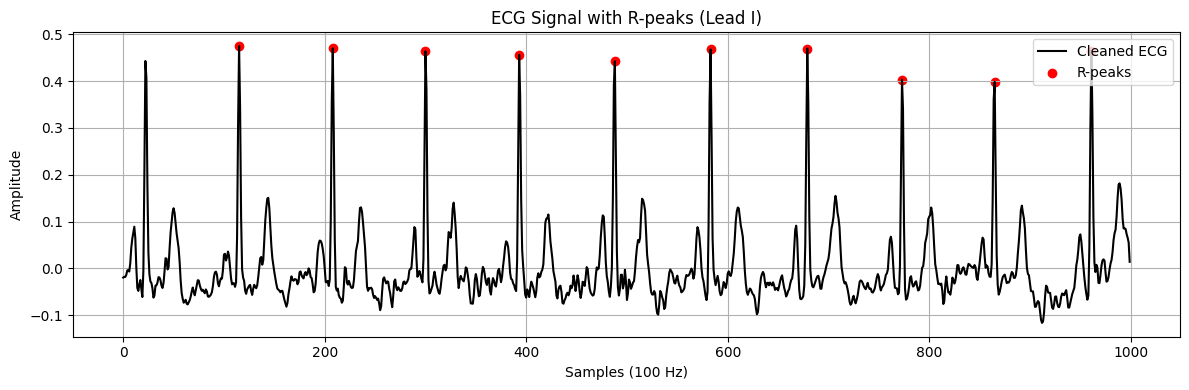

In [16]:
# Let's visualize one ECG as a sanity check:

# Select one ECG lead
ecg_signal = ecg_signals[0][:, 0]

# Clean the ECG
ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=100)

# Detect R-peaks (returns dict and signal DataFrame)
_, rpeaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=100)

# Plot
plt.figure(figsize=(12, 4))
plt.plot(ecg_cleaned, label='Cleaned ECG', color='black')
plt.scatter(rpeaks['ECG_R_Peaks'], ecg_cleaned[rpeaks['ECG_R_Peaks']],
            color='red', label='R-peaks')
plt.title('ECG Signal with R-peaks (Lead I)')
plt.xlabel('Samples (100 Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

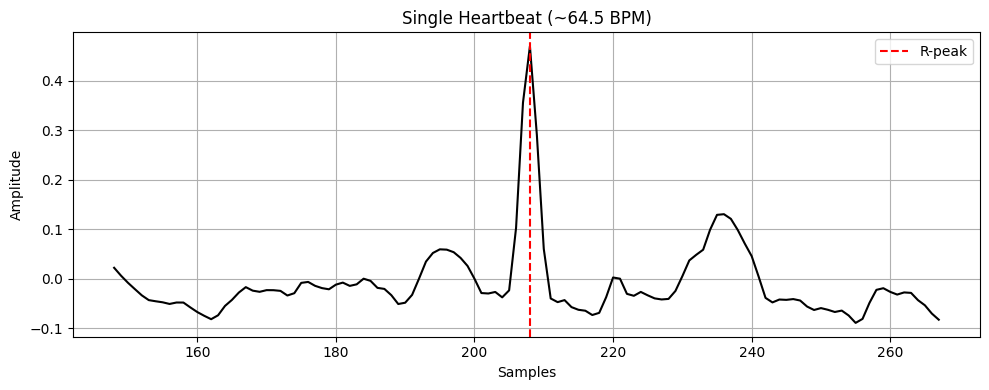

In [17]:
# Pick one R-peak index
r_index = rpeaks['ECG_R_Peaks'][1]  # second peak (avoid edge effects)

# Define window (e.g., 0.6 seconds before and after)
fs = 100  # sampling rate
window = int(0.6 * fs)
start = max(0, r_index - window)
end = min(len(ecg_cleaned), r_index + window)

# Extract heartbeat
heartbeat = ecg_cleaned[start:end]

# Estimate BPM using R-R interval (between first two peaks)
rr_interval = (rpeaks['ECG_R_Peaks'][1] - rpeaks['ECG_R_Peaks'][0]) / fs
bpm = 60 / rr_interval

# Plot
plt.figure(figsize=(10, 4))
plt.plot(np.arange(start, end), heartbeat, color='black')
plt.axvline(r_index, color='red', linestyle='--', label='R-peak')
plt.title(f'Single Heartbeat (~{bpm:.1f} BPM)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### 4. EDA (Exploratory Data Analysis)

In [18]:
# A function will be created to automatically generate histograms and boxplots 
# for the selected columns

def print_histogram_and_boxplot_per_column(df, column_name):
    """
    Generate histograms and boxplots for a selected column
    
    Args:
        df (DataFrame): The DataFrame to analyze.
        column_name (str): The name of the column for which the plots will be generated.
    
    Returns:
        Displays the histogram and boxplot.
    """      
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Calculate mode, median, and mean of the column
    mode_hist = df[column_name].mode() 
    median_hist = df[column_name].median()
    mean_hist = df[column_name].mean()

    # Plot histogram in the first subplot
    sns.histplot(data=df, x=column_name, ax=ax1, kde=True, color='skyblue')
    ax1.set_title(f'Histogram of column "{column_name}"')
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Show mode
    ax1.axvline(mode_hist[0], color='green', linestyle='--', linewidth=2, label='Mode')
    # Show median
    ax1.axvline(median_hist, color='red', linestyle='-', linewidth=2, label='Median')
    # Show mean
    ax1.axvline(mean_hist, color='blue', linestyle='--', linewidth=2, label='Mean')
    ax1.legend()
    
    # Plot boxplot in the second subplot
    sns.boxplot(data=df, x=column_name, ax=ax2, color='#f7dcf6', showmeans=True)
    ax2.set_title(f'Boxplot of column "{column_name}"')
    ax2.grid(True, linestyle='--', alpha=0.7)

    # Adjust spacing
    plt.tight_layout()

    # Display the plots
    plt.show()

In [19]:
# A function will be created to automatically generate bar 
# plots for selected columns

def print_graph_bars_per_column(df, column_name):
    """
    Generate a bar plot for a selected column
    
    Args:
        df (DataFrame): The DataFrame to analyze.
        column_name (str): The name of the column for which the plot will be generated.
    
    Returns:
        Displays the bar plot.
    """
    # Create a subplot
    fig, ax = plt.subplots()
    
    # Plot the bars in the subplot
    sns.countplot(x=df[column_name], data=df)
    ax.set_title(f'Bar plot of column {column_name}')
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust spacing
    plt.tight_layout()
    
    # Show the plot
    plt.show()

In [20]:
# Let's check the numerical and categorical values

quantitative_columns = df_low_moderate.select_dtypes(include=['int', 'float']).columns
qualitative_columns = df_low_moderate.select_dtypes(include=['object']).columns

data_types = []

# "For" loop to get the data types of each column
for col in df_low_moderate.columns:
    if col in quantitative_columns:
        data_type = "Numeric"  # Label for numeric type
    elif col in qualitative_columns:
        data_type = "Object"   # Label for qualitative type
    data_types.append((col, data_type))  # Save column labels in the list


quantitative_df = pd.DataFrame([i for i in data_types if i[1] == "Numeric"],
                               columns=["Variable", "Category"])

qualitative_df = pd.DataFrame([i for i in data_types if i[1] == "Object"],
                              columns=["Variable", "Category"])

print('Quantitative Columns:')
print(tabulate(quantitative_df, headers="keys", tablefmt="psql", showindex=True))
print('\n')
print('Qualitative Columns:')
print(tabulate(qualitative_df, headers="keys", tablefmt="psql", showindex=True))

Quantitative Columns:
+----+------------+------------+
|    | Variable   | Category   |
|----+------------+------------|
|  0 | ecg_id     | Numeric    |
|  1 | scp_weight | Numeric    |
|  2 | AHA code   | Numeric    |
|  3 | age        | Numeric    |
|  4 | sex        | Numeric    |
|  5 | strat_fold | Numeric    |
+----+------------+------------+


Qualitative Columns:
+----+-------------------------------+------------+
|    | Variable                      | Category   |
|----+-------------------------------+------------|
|  0 | scp_code                      | Object     |
|  1 | description                   | Object     |
|  2 | Statement Category            | Object     |
|  3 | SCP-ECG Statement Description | Object     |
|  4 | report                        | Object     |
|  5 | filename_lr                   | Object     |
|  6 | filename_hr                   | Object     |
+----+-------------------------------+------------+


In [21]:
# We are safe to remove the numerical and/or categorical
# columns that we already used to retrieve the ECG signal

columns_to_drop = ['strat_fold', 'description', 'Statement Category', 
                   'SCP-ECG Statement Description', 'report', 'filename_lr', 'filename_hr']

# Remove the columns
df_low_moderate.drop(columns=columns_to_drop, axis=1, inplace=True)

# Print the dataframe
df_low_moderate

,ecg_id,scp_code,scp_weight,AHA code,age,sex
0,1,NORM,100.0,1.0,56.0,1
2,1,SR,0.0,20.0,56.0,1
3,2,NORM,80.0,1.0,19.0,0
4,2,SBRAD,0.0,22.0,19.0,0
5,3,NORM,100.0,1.0,37.0,1
...,...,...,...,...,...,...
61114,21835,SR,0.0,20.0,59.0,1
61115,21836,NORM,100.0,1.0,64.0,1
61116,21836,SR,0.0,20.0,64.0,1
61117,21837,NORM,100.0,1.0,68.0,0


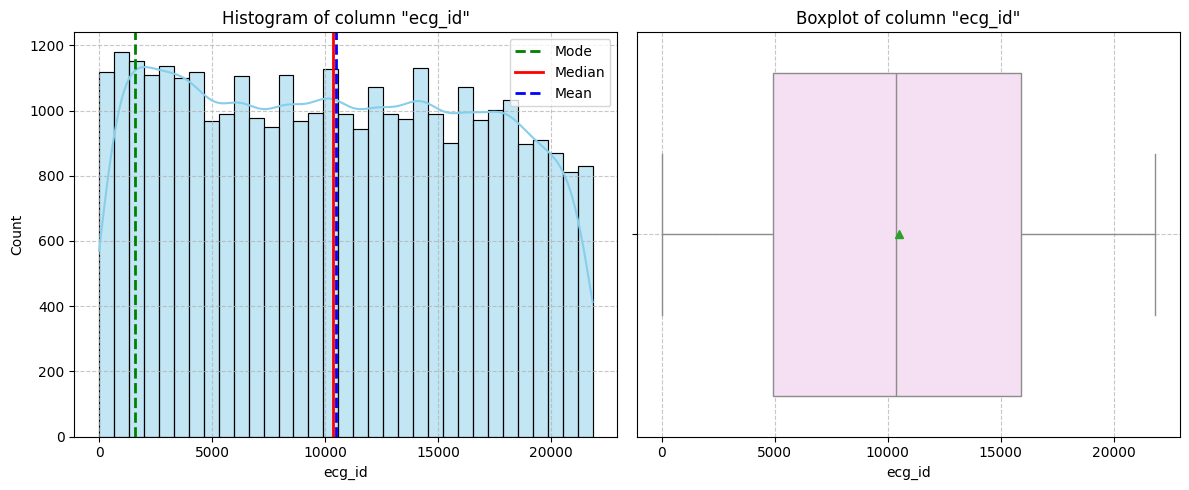

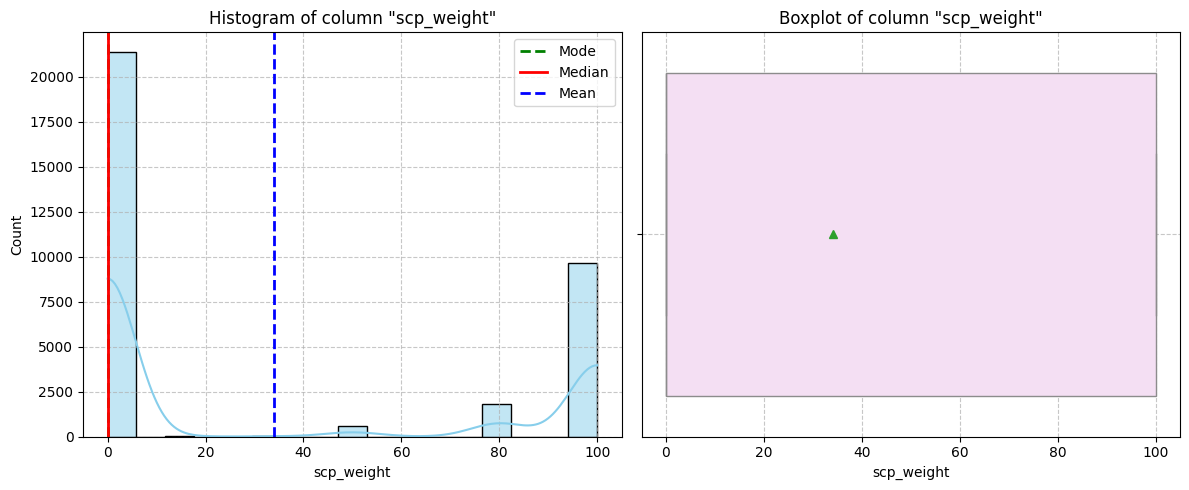

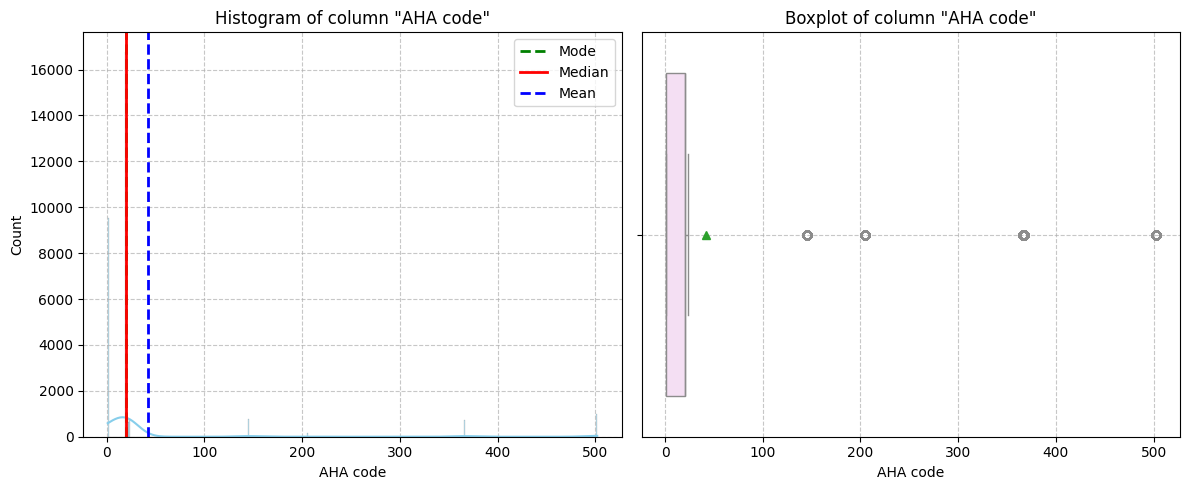

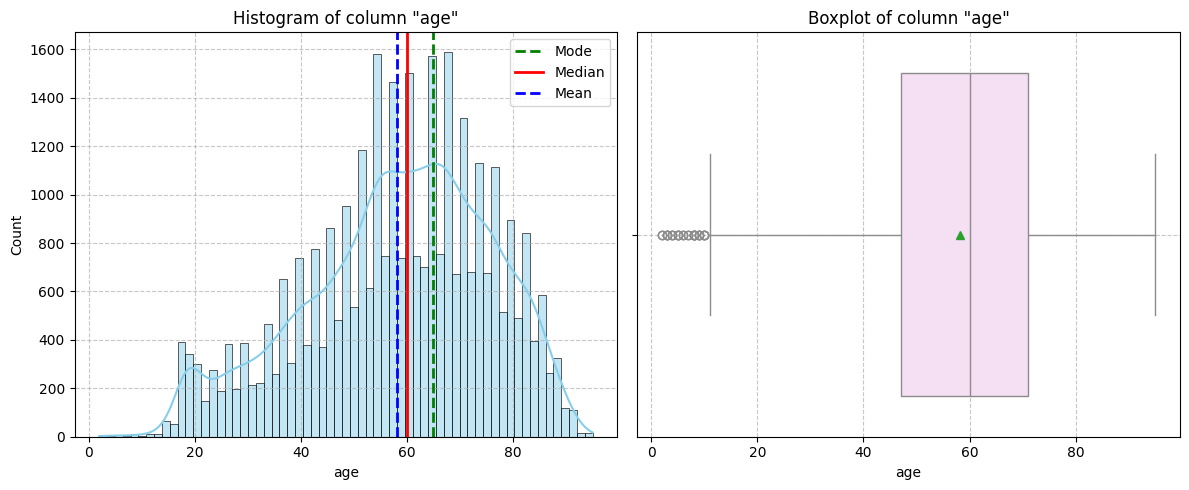

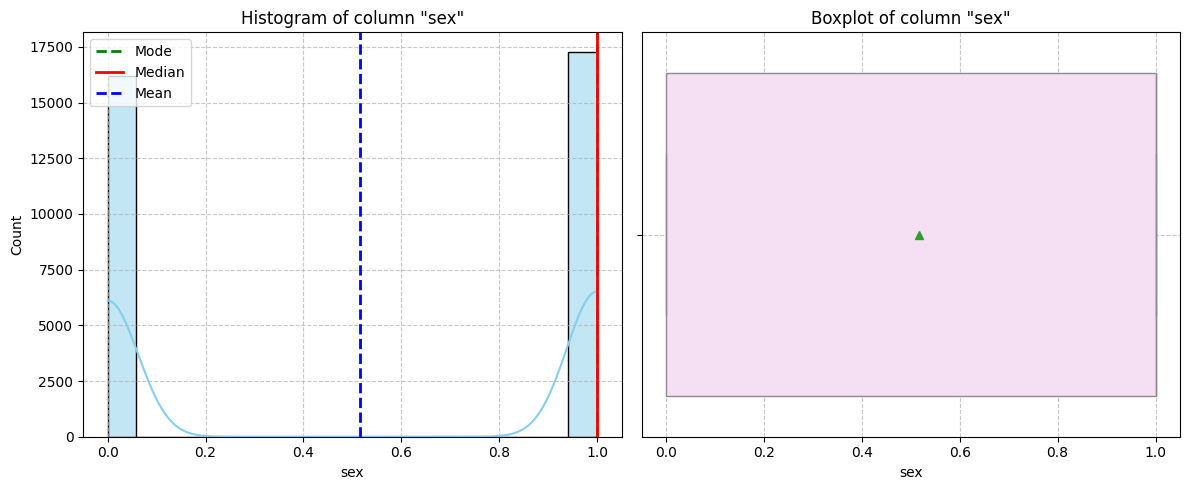

In [22]:
# Let's print the histograms and boxplots per numerical columns

numerical_cols = df_low_moderate.select_dtypes(include=['int', 'float']).columns

for col in numerical_cols:
    print('\n')
    print_histogram_and_boxplot_per_column(df=df_low_moderate, column_name=col)

We see that the `ecg_id` has a symmetric distribution, however, we cannot take it in consideration as a numerical value since this involves the ID of the ECG and is not a numerical quantity.

For the `scp_weight` the same happens, it represents the relevance or confidence of that diagnostic statement according to a human or semi-automated interpretation, so we might want it to be plotted by graph bars instead.

For the `AHA code`, since is a standardized medical label that represents the diagnosis of the ECG using the AHA diagnostic coding system, we could plot it by graph bars instead.

We see that the `age` histogram looks skewed to the left, so we might need to add some transformations.

For the `sex` histogram, since the variable is a binary, we can plot it in graph bars instead.

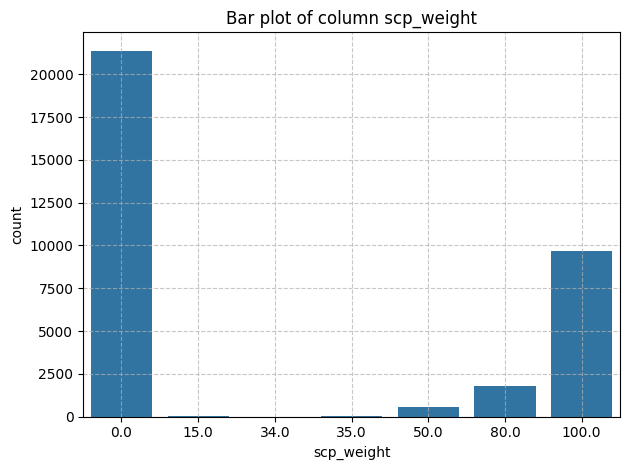

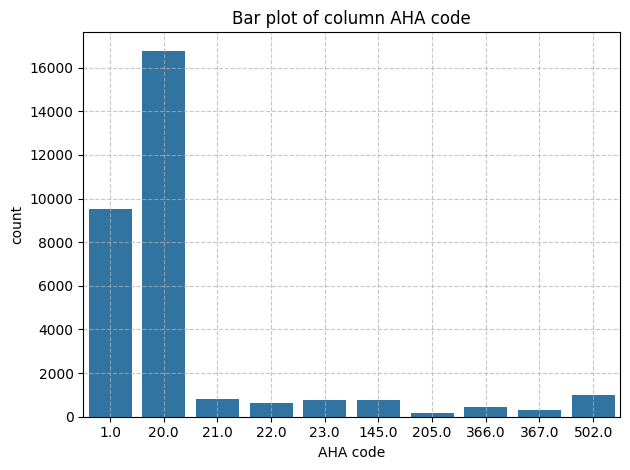

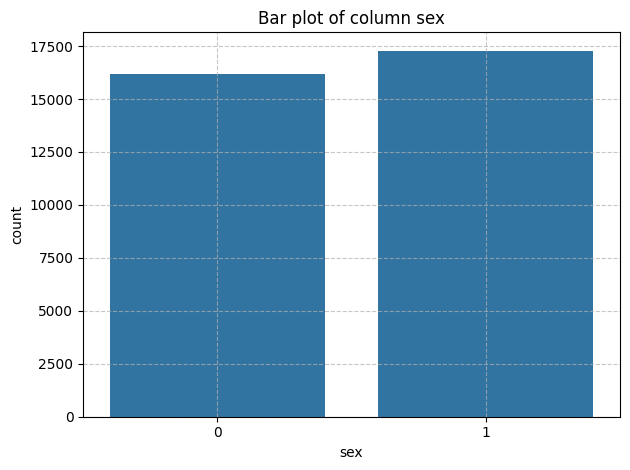

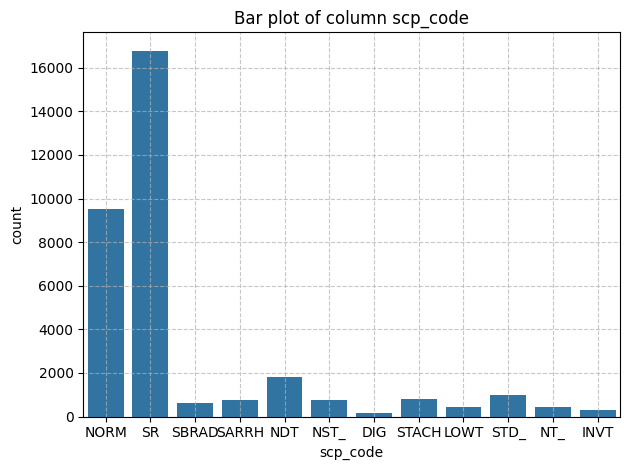

In [23]:
# Let's print the bar graphs for the categorical/binary categories:

object_cols = ['scp_weight', 'AHA code', 'sex', 'scp_code']

for col in object_cols:
    print('\n')
    print_graph_bars_per_column(df=df_low_moderate, column_name=col)

Now that we have seen the distribution of the values, we can follow these steps:

- Transform the `age` column as it is skewed to the left. We suggest using a Box-Cox transformation.
- Divide the data into "X" and "Y".

### 5. FE (Feature Engineering)

In [32]:
# Before following the steps, let's go ahead and look for the missing values:

# To determine the percentage of missing values, we'll use a function 
# that prints them in a table
missing_percentage = df_low_moderate.isna().sum() * 100 / len(df_low_moderate)

# Store results in a DataFrame for formatted table display
df_missing = pd.DataFrame({
    'Column': df_low_moderate.columns,
    'Missing Percentage': missing_percentage.astype(str) + '%'  # Display value with percentage symbol
})

# Print the table with the missing value information
print(tabulate(df_missing, headers='keys', tablefmt='psql', showindex=False))

+------------+----------------------+
| Column     | Missing Percentage   |
|------------+----------------------|
| ecg_id     | 0.0%                 |
| scp_code   | 0.0%                 |
| scp_weight | 0.0%                 |
| AHA code   | 6.727381307853091%   |
| age        | 0.36428784711854284% |
| sex        | 0.0%                 |
+------------+----------------------+


In [33]:
# Let's follow step 1: Box-Cox transform for "age"

# Fill the NaN values in age, as there is a 0.36% of missing values.
# We'll use the median to avoid this, as it is robust for outliers
median_age = df_low_moderate['age'].median()
df_low_moderate['age'] = df_low_moderate['age'].fillna(median_age)

# Ensure all values in 'age' are positive
assert (df_low_moderate['age'] > 0).all(), 'Box-Cox requires all values to be > 0'

# Apply and overwrite
df_low_moderate['age'], fitted_lambda = boxcox(df_low_moderate['age'])

print(f'Optimal lambda used for Box-Cox transformation: {fitted_lambda:.4f}')

Optimal lambda used for Box-Cox transformation: 1.4271


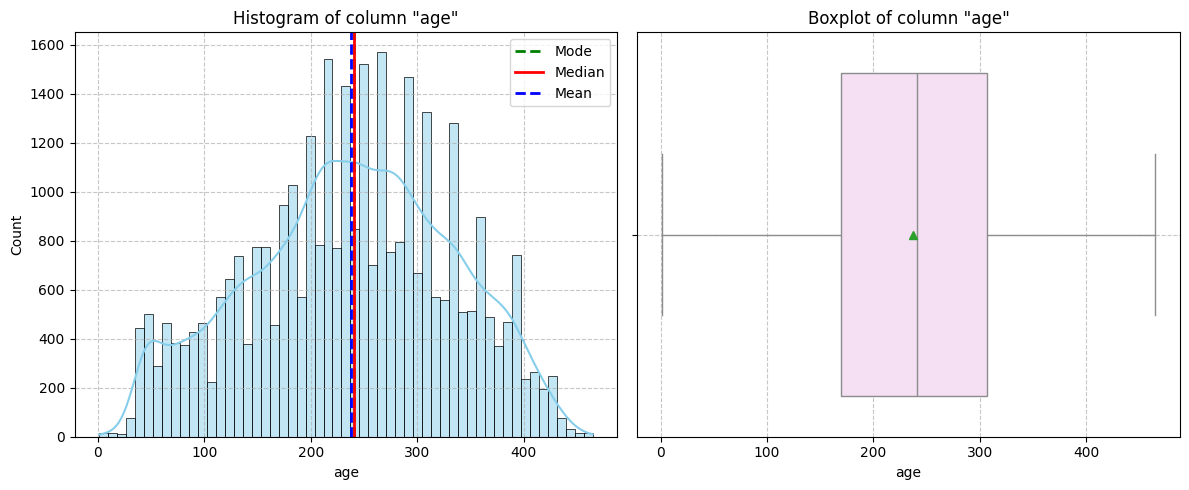

In [34]:
# Let's print the histogram after transforming the values:

print_histogram_and_boxplot_per_column(df=df_low_moderate, column_name='age')

The distribution looks normalized and the boxplot does not include a lot of outliers.

In [42]:
# Since we do not have angiography labels, we simulate a
# synthetic obstruction column with random 0s and 1s as in
# a balanced dataset

# Set a random seed for reproducibility
np.random.seed(42)

# Create a random binary target (balanced)
df_low_moderate["obstruction"] = np.random.randint(0, 2, size=len(df_low_moderate))

# Print the DF
df_low_moderate

,ecg_id,scp_code,scp_weight,AHA code,age,sex,obstruction
0,1,NORM,100.0,1.0,218.265970,1,0
2,1,SR,0.0,20.0,218.265970,1,1
3,2,NORM,80.0,1.0,46.121319,0,0
4,2,SBRAD,0.0,22.0,46.121319,0,0
5,3,NORM,100.0,1.0,120.504249,1,0
...,...,...,...,...,...,...,...
61114,21835,SR,0.0,20.0,235.195902,1,1
61115,21836,NORM,100.0,1.0,264.233523,1,0
61116,21836,SR,0.0,20.0,264.233523,1,1
61117,21837,NORM,100.0,1.0,288.175640,0,0


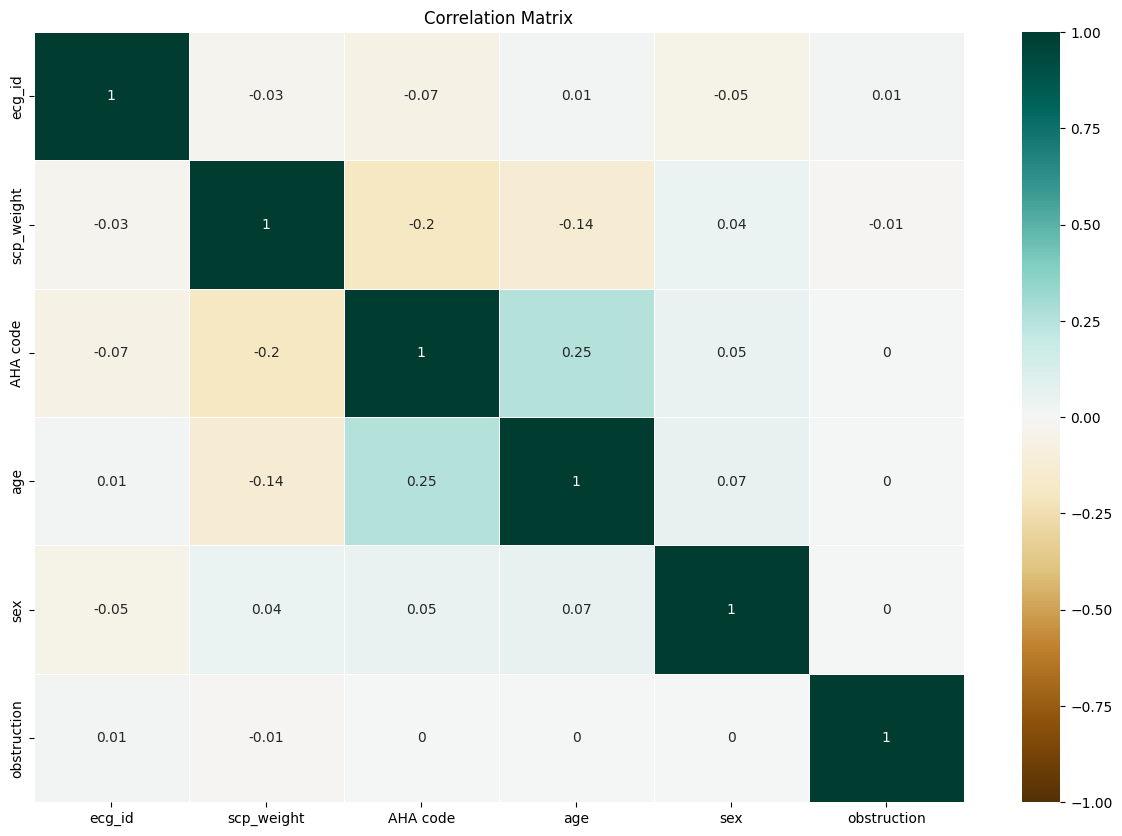

In [43]:
# Now, let's print a correlation matrix to see the variables we can include

df_numeric = df_low_moderate.select_dtypes(include=['int', 'float'])

correlation_matrix = round(df_numeric.corr(), 2)

plt.figure(figsize=(15,10))
sns.heatmap(correlation_matrix, vmin=-1, vmax=1, annot=True, linewidths=0.5, cmap='BrBG')
plt.title('Correlation Matrix')
plt.show()

Our hybrid model will include:

X = metadata (`age`, `sex`) + `ecg_signals`

Y = `obstruction`

### 6. Modelling

In [45]:
# Combine metadata + signals
X_meta = df_low_moderate[['age', 'sex']].reset_index(drop=True)
X_signal = ecg_signals  # already aligned and reset

# Target
y = df_low_moderate['obstruction'].values

# We'll split into: train (70%), val (15%), test (15%)

# First split into train (70%) and temp (30%)
X_meta_train, X_meta_temp, X_signal_train, X_signal_temp, y_train, y_temp = train_test_split(
    X_meta, X_signal, y, test_size=0.30, stratify=y, random_state=42
)

# Then split temp into val (15%) and test (15%)
X_meta_val, X_meta_test, X_signal_val, X_signal_test, y_val, y_test = train_test_split(
    X_meta_temp, X_signal_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

In [46]:
# Define input shapes
signal_shape = (1000, 12)
meta_shape = (2,)  # age + sex

# Inputs
input_signal = layers.Input(shape=signal_shape, name="ecg_input")
input_meta = layers.Input(shape=meta_shape, name="meta_input")

# Signal branch
x = layers.Conv1D(32, 5, activation="relu")(input_signal)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(64, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)

# Meta branch
m = layers.Dense(16, activation="relu")(input_meta)

# Concatenate both
combined = layers.concatenate([x, m])
combined = layers.Dense(64, activation="relu")(combined)
combined = layers.Dropout(0.3)(combined)
output = layers.Dense(1, activation="sigmoid")(combined)

# Model
model = models.Model(inputs=[input_signal, input_meta], outputs=output)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [47]:
# Convert all sets to numpy arrays
X_meta_train = X_meta_train.values
X_meta_val = X_meta_val.values
X_meta_test = X_meta_test.values

# Train
history = model.fit(
    x={"ecg_input": X_signal_train, "meta_input": X_meta_train},
    y=y_train,
    validation_data=(
        {"ecg_input": X_signal_val, "meta_input": X_meta_val},
        y_val
    ),
    epochs=10,
    batch_size=64
)

Epoch 1/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5051 - loss: 4.4264 - val_accuracy: 0.4983 - val_loss: 0.6944
Epoch 2/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.4920 - loss: 0.6940 - val_accuracy: 0.4890 - val_loss: 0.6932
Epoch 3/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4936 - loss: 0.6937 - val_accuracy: 0.5011 - val_loss: 0.6931
Epoch 4/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5010 - loss: 0.6932 - val_accuracy: 0.4836 - val_loss: 0.6936
Epoch 5/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4956 - loss: 0.6932 - val_accuracy: 0.5009 - val_loss: 0.6932
Epoch 6/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.4944 - loss: 0.6933 - val_accuracy: 0.4862 - val_loss: 0.6935
Epoch 7/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5027 - loss: 0.6932 - val_accuracy: 0.5011 - val_loss: 0.6932
Epoch 8/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5081 - loss: 0.6931 - val_accu

In [49]:
# Predict on validation set
y_pred_val = (model.predict({"ecg_input": X_signal_val, "meta_input": X_meta_val}) > 0.5).astype(int)

print("\n>> Accuracy:")
print('Accuracy - Train:', model.evaluate({"ecg_input": X_signal_train, "meta_input": X_meta_train}, y_train, verbose=0)[1])
print('Accuracy - Val:', metrics.accuracy_score(y_val, y_pred_val))

print("\n>> Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_val))

print("\n>> Classification Report:")
print(classification_report(y_val, y_pred_val))

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

>> Accuracy:
Accuracy - Train: 0.49869897961616516
Accuracy - Val: 0.4997013736810671

>> Confusion Matrix:
[[2099  407]
 [2106  411]]

>> Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.84      0.63      2506
           1       0.50      0.16      0.25      2517

    accuracy                           0.50      5023
   macro avg       0.50      0.50      0.44      5023
weighted avg       0.50      0.50      0.44      5023

